# CONTRASTIVE ATTENTION FOR ASPECT EXTRACTION

In [ ]:
import numpy as np
from collections import defaultdict


In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess

nltk.download('punkt')

df = pd.read_csv("uber_reviews_without_reviewid.csv")  
reviews = df["content"].dropna().tolist()

tokenized_reviews = [simple_preprocess(review) for review in reviews]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=200,   
    window=15,
    min_count=3,       
    workers=4,
    sg=1               
)

w2v_model.save("uber_word2vec.model")


In [ ]:
model = Word2Vec.load("uber_word2vec.model")

print(model.wv.most_similar("driver", topn=10))


[('car', 0.8337459564208984), ('behavior', 0.830902099609375), ('name', 0.8112234473228455), ('man', 0.8108029961585999), ('tipped', 0.8003377318382263), ('condition', 0.7971303462982178), ('early', 0.7966358661651611), ('luggage', 0.7944991588592529), ('heavy', 0.7923715114593506), ('spotless', 0.7915148138999939)]


# DEFINING CANONICAL SEED ASPECTS

In [ ]:
from collections import defaultdict

canonical_aspects = [
    "driver", "ride", "app", "fare", "support", "payment",
    "booking",  "car", "interface", "service",
    "map", "location", "tracking", "navigation", "speed",
     "refund", "issue", "experience",
    "agent", "customer", "drop", "pickup", "wallet", "route",
    "destination", "delay", "wait","uber"
]


# Create the aspect mapping dictionary
aspect_mapping = defaultdict(lambda: None)
similarity_threshold = 0.75

# Ensure all keys are lowercase and trimmed
canonical_aspects = [canon.strip().lower() for canon in canonical_aspects]

for canon in canonical_aspects:
    aspect_mapping[canon] = canon  # self-map
    try:
        similar_words = w2v_model.wv.most_similar(canon, topn=10)
        for word, score in similar_words:
            if score > similarity_threshold:
                aspect_mapping[word] = canon
    except KeyError:
        print(f"'{canon}' not in Word2Vec vocabulary — skipped.")
        continue



'speed' not in Word2Vec vocabulary — skipped.


In [47]:
for word, mapped_to in aspect_mapping.items():
    print(f"{word} → {mapped_to}")


driver → driver
car → car
behavior → experience
name → driver
man → driver
tipped → driver
condition → driver
early → driver
luggage → car
heavy → driver
spotless → car
ride → ride
confirmation → ride
coming → ride
plus → ride
passenger → ride
whenever → ride
increasing → ride
trip → ride
bookings → ride
arrival → pickup
gets → ride
app → app
fare → destination
shown → fare
increased → destination
showing → fare
reaching → destination
while → booking
distance → route
shows → booking
changes → booking
initial → booking
increase → booking
support → customer
contact → support
chat → support
resolution → customer
resolve → customer
mail → customer
customer → customer
help → support
ai → customer
team → support
complaint → customer
payment → payment
upi → wallet
method → wallet
wallet → wallet
cash → payment
mode → wallet
online → payment
pending → wallet
digital → wallet
unable → payment
add → wallet
booking → booking
initially → booking
increases → booking
drove → car
gentleman → car
she 

In [49]:
seed_vectors = {
    seed: w2v_model.wv[seed] 
    for seed in canonical_aspects 
    if seed in w2v_model.wv
}


In [ ]:
# manually edited file
refined_df = pd.read_csv("updated_aspect_mappings.csv")

aspect_mapping = dict(zip(refined_df["Original_Word"], refined_df["Mapped_Aspect"]))

## PERFORMING GLOBAL ASPECT MAPPING USING USING COSINE SIM AND MANUALLY MAPPED ASPECT LABELS

In [51]:
for word, mapped_to in aspect_mapping.items():
    print(f"{word} → {mapped_to}")

driver → driver
car → car
trip → ride
ride → ride
journey → car
she → car
vehicle → car
drive → driver
drove → driver
arrived → wait
rider → driver
bike → car
request → ride
destination → destination
confirmation → ride
increased → fare
rides → ride
app → app
application → app
company → app
experience → experience
aap → app
platform → uber
seen → -
ever → app
services → service
life → experience
travel → service
fare → fare
booking → booking
shown → fare
increase → fare
showing → fare
shows → fare
while → ride
reaching → destination
double → booking
fair → fare
changes → route
support → support
number → customer
contact → support
proper → support
care → support
team → support
help → support
chat → support
customer → customer
issues → support
provide → service
payment → payment
cash → payment
upi → payment
method → payment
online → payment
amount → payment
pending → payment
which → -
mode → payment
wallet → payment
add → payment
price → fare
cab → car
auto → car
booked → booking
initial

In [52]:

aspect_matrix = [w2v_model.wv[word] for word in seed_vectors if word in w2v_model.wv]


# DEFINING CONTRASTIVE ATTENTION

## using RBF kernel to give each word a bounded score between 0 and 1 based on its similarity with an aspect

# 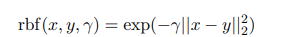

The attention for a given word is thus the sum of
the RBF responses of all vectors in the aspect defined set, divided by
the sum of the RBF responses of the vectors to all other words in the sentence

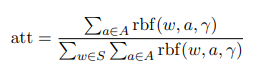

In [ ]:

def rbf(x, y, gamma=0.03):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

def contrastive_attention(tokens, model, aspect_matrix, gamma=0.03):
    scores = []
    for word in tokens:
        if word in model.wv:
            w_vec = model.wv[word]
            attention = sum(rbf(w_vec, a_vec, gamma) for a_vec in aspect_matrix)
            scores.append((word, attention))
    total = sum(att for _, att in scores)
    if total == 0:
        return []
    return [(word, att / total) for word, att in scores]


In [54]:
# Assuming refined_df is already loaded
# Mapping from word -> canonical aspect
aspect_map = dict(zip(
    refined_df["Original_Word"].str.lower().str.strip(),
    refined_df["Mapped_Aspect"].str.lower().str.strip()
))

def normalize_aspect(word):
    return aspect_map.get(word.lower(), None)



In [68]:
final_aspects = []

for tokens in tokenized_reviews:
    att_scores = contrastive_attention(tokens, w2v_model, aspect_matrix)
    filtered = [normalize_aspect(w) for w, score in att_scores if score > 0.5 and normalize_aspect(w) is not None]
    final_aspects.append(list(set(filtered)))


## USING MANUALLY LABELLED ASPECTS DATASET FOR EVALUATION OF THE MODEL

In [69]:
gold_df= pd.read_csv("Gold_Standard__Only_B-ASP_Considered_.csv")
gold_df

,review,aspect,sentiment,opinion
0,"Efficient, driver is professional, cost is rea...",driver,positive,friendly/nice/polite
1,"Efficient, driver is professional, cost is rea...",fare,positive,cheap/reasonable
2,Waiting charge is extra bad experience,wait,negative,waiting
3,Good service,service,positive,good/great/nice
4,Worst customer service On 19/11/24 I booked an...,driver,neutral,NaN
...,...,...,...,...
104,Don't install this uber app.. totally waste of...,driver,neutral,NaN
105,Don't install this uber app.. totally waste of...,app,neutral,NaN
106,Don't install this uber app.. totally waste of...,service,negative,bad/poor/worst
107,make app user friendly.one can understand easily,app,neutral,NaN


In [70]:
df_reviews = df["content"].tolist()


In [71]:
from nltk.tokenize import word_tokenize

gold_sentences = [word_tokenize(str(r).lower()) for r in gold_df["review"]]


In [72]:
sent = [word_tokenize(str(r).lower()) for r in df["content"]]



In [73]:
cat_predicted_aspects = []

for tokens in sent:
    att_scores = contrastive_attention(tokens, w2v_model, aspect_matrix)
    filtered = [normalize_aspect(w) for w, score in att_scores if score > 0.1 and normalize_aspect(w) is not None]
    cat_predicted_aspects.append(list(set(filtered)))

In [74]:
df["cat_predicted_aspects"]= cat_predicted_aspects

In [ ]:
# df.to_csv("cat_extracted_aspects",index=True)

In [75]:
gold_predicted_aspects = []

for tokens in gold_sentences:
    att_scores = contrastive_attention(tokens, w2v_model, aspect_matrix)
    filtered = [normalize_aspect(w) for w, score in att_scores if score > 0.1 and normalize_aspect(w) is not None]
    gold_predicted_aspects.append(list(set(filtered)))


In [76]:
gold_df["predicted_aspects_contrastive"] = gold_predicted_aspects


In [ ]:

def group_aspects_by_review(df, review_col="review", aspect_col="aspect"):
    grouped = defaultdict(set)
    for _, row in df.iterrows():
        grouped[row[review_col]].add(row[aspect_col].lower())  # normalize case
    return grouped

gold_aspects = group_aspects_by_review(gold_df)




In [78]:
predicted_aspects = {
    review: set([a.lower() for a in aspects])
    for review, aspects in zip(gold_df["review"], gold_df["predicted_aspects_contrastive"])
}


In [ ]:
true_positives = 0
false_positives = 0
false_negatives = 0

comparison_data = []

for review in gold_aspects:
    gold_set = gold_aspects[review]
    pred_set = predicted_aspects.get(review, set())
    
    tp = gold_set & pred_set
    fp = pred_set - gold_set
    fn = gold_set - pred_set

    true_positives += len(tp)
    false_positives += len(fp)
    false_negatives += len(fn)

    comparison_data.append({
        "review": review,
        "gold_aspects": list(gold_set),
        "predicted_aspects": list(pred_set),
        "true_positives": list(tp),
        "false_positives": list(fp),
        "false_negatives": list(fn)
    })

comparison_df = pd.DataFrame(comparison_data)


In [80]:
precision = true_positives / (true_positives + false_positives + 1e-10)
recall = true_positives / (true_positives + false_negatives + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)

print(f"Aspect Extraction Evaluation:\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Aspect Extraction Evaluation:
Precision: 0.719, Recall: 0.422, F1: 0.532


In [23]:
comparison_df

,review,gold_aspects,predicted_aspects,true_positives,false_positives,false_negatives
0,"Efficient, driver is professional, cost is rea...","[driver, fare]","[driver, fare]","[driver, fare]",[],[]
1,Waiting charge is extra bad experience,[wait],"[wait, experience]",[wait],[experience],[]
2,Good service,[service],[service],[service],[],[]
3,Worst customer service On 19/11/24 I booked an...,"[driver, app, service]",[],[],[],"[driver, app, service]"
4,Reliable and timescale and easy tovl use with ...,[fare],[fare],[fare],[],[]
...,...,...,...,...,...,...
78,4 days ago I requested a cash trip for my mom....,[driver],[],[],[],[driver]
79,worst & scam app. Customer ko kam price dikhak...,"[driver, app, fare]",[],[],[],"[driver, app, fare]"
80,Don't install this uber app.. totally waste of...,"[driver, app, service]",[],[],[],"[driver, app, service]"
81,make app user friendly.one can understand easily,[app],"[map, app]",[app],[map],[]


In [ ]:
#  Replacing empty lists with ['uber']
df['cat_predicted_aspects'] = df['cat_predicted_aspects'].apply(
    lambda aspects: ['uber'] if not aspects else aspects
)

In [ ]:
 #Expanding each aspect into a separate row
df_exploded = df.explode('cat_predicted_aspects').reset_index(drop=True)

In [ ]:
# df_exploded.to_csv("cat_extracted_asp",index = True)

# Performing sentiment analysis using roberta

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv("cat_extracted_asp_labeled_sent.csv")
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

c:\Users\aayan\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
from torch.optim import AdamW


In [29]:

# Custom PyTorch Dataset
class ABSADataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.texts = dataframe['aspect'] + " [SEP] " + dataframe['review']
        self.labels = dataframe['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.texts.iloc[idx], 
                                padding='max_length',
                                truncation=True, 
                                max_length=self.max_len,
                                return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
# Preparing  Dataloaders
train_ds = ABSADataset(train_df, tokenizer)
val_ds = ABSADataset(val_df, tokenizer)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop
epochs = 10
loss_fn = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {total_loss:.4f}")

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=1)
            preds.extend(pred.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    acc = accuracy_score(trues, preds)
    print(f"Validation Accuracy: {acc:.4f}")


Epoch 1/10 - Training loss: 22.7463
Validation Accuracy: 0.5250
Epoch 2/10 - Training loss: 17.4121
Validation Accuracy: 0.8750
Epoch 3/10 - Training loss: 11.6563
Validation Accuracy: 0.8500
Epoch 4/10 - Training loss: 7.2877
Validation Accuracy: 1.0000
Epoch 5/10 - Training loss: 4.0110
Validation Accuracy: 0.9000
Epoch 6/10 - Training loss: 2.6257
Validation Accuracy: 1.0000
Epoch 7/10 - Training loss: 2.3926
Validation Accuracy: 0.9000
Epoch 8/10 - Training loss: 1.8024
Validation Accuracy: 0.9750
Epoch 9/10 - Training loss: 1.0916
Validation Accuracy: 0.9250
Epoch 10/10 - Training loss: 0.3378
Validation Accuracy: 0.9250


In [34]:
# Save model
model.save_pretrained("roberta_absa_manual")
tokenizer.save_pretrained("roberta_absa_manual")

    

('roberta_absa_manual\\tokenizer_config.json',
 'roberta_absa_manual\\special_tokens_map.json',
 'roberta_absa_manual\\vocab.json',
 'roberta_absa_manual\\merges.txt',
 'roberta_absa_manual\\added_tokens.json')


✅ Validation Accuracy: 0.9250

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      1.00      0.83         5
    Positive       0.95      1.00      0.98        21
     Neutral       1.00      0.79      0.88        14

    accuracy                           0.93        40
   macro avg       0.89      0.93      0.90        40
weighted avg       0.94      0.93      0.92        40



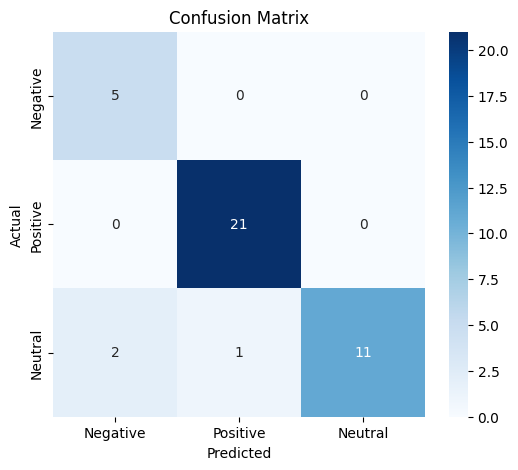

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Collect true and predicted labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f" Validation Accuracy: {accuracy:.4f}")

# 2. Detailed Metrics
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive", "Neutral"]))

# 3. Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive", "Neutral"],
            yticklabels=["Negative", "Positive", "Neutral"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [39]:
import torch.nn.functional as F


In [ ]:


df = pd.read_csv("cat_extracted_asp.csv")  
df = df.dropna(subset=['content', 'cat_predicted_aspects'])

#  fine-tuned model
model_path = "roberta_absa_manual"
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model.eval()
device = torch.device("cpu")
model = model.to(device)

def predict_sentiment_score(aspect, review):
    text = aspect + " [SEP] " + review
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1).squeeze().cpu().numpy()
    return {
        "negative_score": float(probs[0]),
        "positive_score": float(probs[1]),
        "neutral_score": float(probs[2]),
        "predicted_label": ["negative", "positive", "neutral"][probs.argmax()]
    } 

# # Run predictions
# df['aspect_sentiment'] = df.apply(
#     lambda row: predict_sentiment(str(row['cat_predicted_aspects']), str(row['content'])), axis=1
# )

results = df.apply(
    lambda row: predict_sentiment_score(str(row['cat_predicted_aspects']), str(row['content'])),
    axis=1, result_type='expand'
)

df = pd.concat([df, results], axis=1)



In [41]:
df

,Unnamed: 0,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cat_predicted_aspects,negative_score,positive_score,neutral_score,predicted_label
0,0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005,uber,0.000526,0.999051,0.000423,positive
1,1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005,uber,0.000488,0.999041,0.000471,positive
2,2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001,uber,0.001119,0.001687,0.997194,neutral
3,3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005,uber,0.000526,0.999051,0.000423,positive
4,4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005,uber,0.000889,0.003090,0.996021,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13228,13228,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000,ride,0.994571,0.003354,0.002075,negative
13229,13229,User_11996,NaN,Worst experience after 10pm in Hyde cityno aut...,5,0,4.552.10000,2024-11-24 21:56:10,NaN,NaN,4.552.10000,car,0.994688,0.003126,0.002186,negative
13230,13230,User_11997,NaN,Exceptional,5,0,4.552.10000,2024-11-24 21:52:21,NaN,NaN,4.552.10000,uber,0.002406,0.002983,0.994611,neutral
13231,13231,User_11998,NaN,Good Service.,5,0,4.553.10000,2024-11-24 21:50:30,NaN,NaN,4.553.10000,service,0.000574,0.998942,0.000483,positive


In [ ]:

df.to_csv("cat_extracted_with_sentiment_score.csv", index=False)
print(" Prediction complete. File saved as 'cat_extracted_with_sentiment.csv'")